# PCA TEST

In [1]:
import pyspark
import nltk
import warnings
import csv
import re
import datetime
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql import Row
from pyspark.sql import functions as F

from pyspark.sql.window import Window
from pyspark.sql.types import *
# from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import monotonically_increasing_id,row_number
from pyspark.sql.functions import col, unix_timestamp, to_date, lit, regexp_replace, lower, format_number

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from asyncio.windows_events import NULL
from gc import collect
from numpy import empty, row_stack
warnings.filterwarnings('ignore')

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import StandardScaler, MinMaxScaler, PCA, PCAModel, VectorAssembler
from pyspark.ml.linalg import Vector, Vectors
from  pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# Creating a spark session

spark = SparkSession.builder.appName('DM').config("spark.executor.heartbeatInterval", "110000ms ").getOrCreate() 

In [4]:
# Creating path variables for all available data

data_path = "" # Path to Data folder
lexicon_path = "" # Path to lexicon data for sentiment analysis
# News data - find news text data about companies and their stock
news_path = "" # Path to news data
main_data_path = data_path + "\\final_data_COMPLETED.csv" # Path to DJUSCG index data

In [5]:
# Loading DJUSCG price data into data_frame as spark dataframe

data_frame = spark.read.format('csv').option('header','true').load(main_data_path)

In [61]:
# Extracting date from dataframe and converting it to list

date = data_frame.select('Date').rdd.flatMap(lambda x: x).collect() # Date list

In [6]:
# Removing 'M' in volume column

data_frame = data_frame.withColumn('Volume',F.regexp_replace('Volume', 'M', ''))

In [7]:
# Converting attribute Date from type String to type Timestamp

data_frame = data_frame.withColumn('Price', data_frame.Price.cast(DoubleType()))
data_frame = data_frame.withColumn('Open', data_frame.Open.cast(DoubleType())) 
data_frame = data_frame.withColumn('Chg', data_frame.Chg.cast(DoubleType()))
data_frame = data_frame.withColumn('High', data_frame.High.cast(DoubleType()))
data_frame = data_frame.withColumn('Low', data_frame.Low.cast(DoubleType()))
data_frame = data_frame.withColumn('Volume', data_frame.Volume.cast(DoubleType()))
data_frame = data_frame.withColumn('Sentiment Score', F.col('Sentiment Score').cast(DoubleType()))
data_frame = data_frame.withColumn('RSI', data_frame.RSI.cast(DoubleType()))
data_frame = data_frame.withColumn('SMA', data_frame.SMA.cast(DoubleType()))
data_frame = data_frame.withColumn('K', data_frame.K.cast(DoubleType()))
data_frame = data_frame.withColumn('UnEmp Val', F.col('Unemp Val').cast(DoubleType()))
data_frame = data_frame.withColumn('GDP Val', F.col('GDP Val').cast(DoubleType()))
data_frame = data_frame.withColumn('Inflation Rate', F.col('Inflation Rate').cast(DoubleType()))
data_frame = data_frame.withColumn('tmwClose', data_frame.tmwClose.cast(DoubleType()))
data_frame = data_frame.withColumn('GR', data_frame.GR.cast(DoubleType()))

In [8]:
# One hot encoder alternate

data_frame = data_frame.withColumn('trend', F.when(F.col('trend')=="UP",1.0).otherwise(0.0))
data_frame = data_frame.withColumn('tmwTrend', F.when(F.col('tmwTrend')=="UP",1.0).otherwise(0.0))

In [9]:
# Extracting columns name from dataframe

cols = (data_frame.columns)

In [10]:
# Removing unnecessary columns

cols.remove('Date')

In [11]:
assembler = VectorAssembler(inputCols = cols, outputCol = 'features')

In [12]:
features = assembler.transform(data_frame)

In [13]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([534.7, 541.22, -0.0143, 541.22, 529.31, 116.04, 0.1359, 50.05, 577.43, 30.15, 0.0, 1.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([536.49, 535.06, 0.0033, 537.81, 532.86, 91.58, 0.3496, 50.1, 575.03, 30.87, 1.0, 0.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([531.52, 535.21, -0.0093, 535.21, 528.81, 118.1, 0.2594, 50.11, 572.31, 28.86, 0.0, 1.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([521.06, 530.86, -0.0197, 530.86, 519.45, 116.33, 0.1397, 50.13, 569.15, 24.61, 0.0, 1.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([515.79, 521.72, -0.0101, 524.74, 514.69, 105.77, 0.3696, 50.12, 566.28, 22.47, 0.0, 1.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([519.74, 516.04, 0.0077, 521.35, 513.93, 99.11, 0.5838, 50.15, 562.72, 24.07, 1.0, 0.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([523.14, 520.3, 0.0065, 525.82, 518.33, 99.53, 0.9871, 50.13, 559.7, 25.45, 1.0, 0.0, 4.8, 101.0073, 1.4, 2.99]),
 DenseVector([512.6, 523.4, -0.0201, 525.08, 511.89, 119.08, 0.7591, 50.09, 557.65, 21.17, 0.0

In [14]:
pca = PCA(k=3, inputCol = 'features', outputCol = 'pcaFeatures')
model = pca.fit(features)

In [15]:
result_pca = model.transform(features).select('pcaFeatures')
result_pca.show(truncate = False)

+-------------------------------------------------------------+
|pcaFeatures                                                  |
+-------------------------------------------------------------+
|[-487.65078625650773,-1110.870196118579,-22.879623292858533] |
|[-463.553661880606,-1115.8119902110236,-24.92302035504191]   |
|[-486.6200464018906,-1101.3647982403027,-22.247289840277134] |
|[-480.387944640825,-1088.0636489821816,-20.832196855047155]  |
|[-466.38449590676396,-1079.3465906257566,-20.300498237272357]|
|[-458.84391574066956,-1077.6687413163183,-21.323755864958724]|
|[-461.1613264982671,-1083.1735519707834,-23.16763838140097]  |
|[-477.1889381320558,-1069.4790333063129,-20.624684169418646] |
|[-478.6092719220253,-1058.461793792629,-19.008254042938706]  |
|[-506.1537387157248,-1039.262407311938,-15.062572189395253]  |
|[-463.35517852514107,-1053.709741541805,-19.0980890898706]   |
|[-479.67297011455764,-1039.8221405637878,-16.497832377868672]|
|[-463.9091864447644,-1050.1350782595473

In [16]:
rdd = result_pca.rdd.sample(False, 0.1)

In [17]:
x = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

y = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

z = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

In [18]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

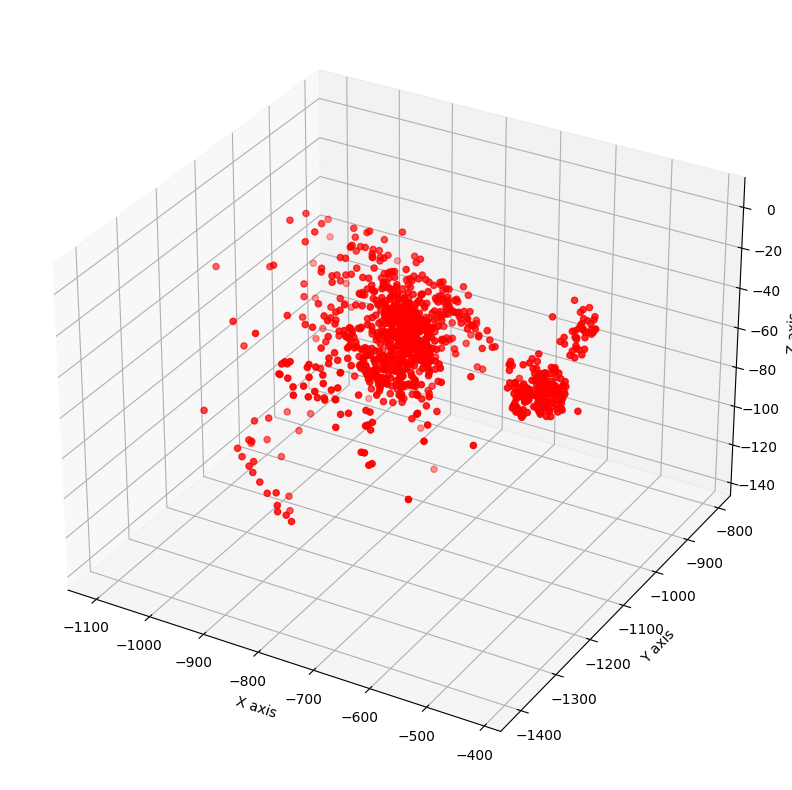

In [19]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(x, y, z, c = 'r', marker = 'o')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [ ]:
# Removing unnecessary columns
cols.remove('tmwClose')

# MULTILINEAR REGRESSION

In [20]:
# Selecting all columns except "Price" -> (to be predicted)

Lcols = cols[1:]

In [21]:
# Creating a vector consisting of input columns and naming it as 'features'

Vassembler = VectorAssembler(inputCols = Lcols, outputCol = 'features')

In [22]:
# Adding features column to the data_frame

vpp_df = Vassembler.transform(data_frame)

In [23]:
# Selecting only features and price into a separate dataframe

final_df = vpp_df.select('features','Price')

In [24]:
# Splitting the train data and test data

trainData, testData = final_df.randomSplit([0.7,0.3])

In [25]:
# Creating a Multi Linear Regressor handle

lm = LinearRegression(labelCol = 'Price')

In [26]:
# Fitting the train data into the model

model = lm.fit(trainData)

In [27]:
# Evaluating the model using the test data and storing the result in res

res = model.evaluate(testData)

In [28]:
# Displaying test data

y_test = testData.select('Price')

In [29]:
# Selecting features from test data

x_test = testData.select('features')

In [30]:
# Predicting the y values (Price) using test features (x_test)

predictions = model.transform(x_test)

In [31]:
predictions.show(truncate = False)

+---------------------------------------------------------------------------------------------------+------------------+
|features                                                                                           |prediction        |
+---------------------------------------------------------------------------------------------------+------------------+
|[480.21,-0.029,486.55,460.48,668.08,0.2253,74.59,525.0,8.33,0.0,1.0,4.4,109.198128767,1.5,104.05]  |418.26351060520267|
|[507.87,0.0155,516.41,507.87,98.1,0.7534,49.97,555.48,22.39,1.0,0.0,4.8,101.007284508,1.4,2.99]    |515.6610241653543 |
|[510.5,0.0047,517.06,508.72,113.01,0.3315,49.97,560.91,21.76,1.0,0.0,4.9,101.007284508,1.0,2.55]   |514.9178274290521 |
|[512.64,0.0019,516.82,508.43,123.97,0.7968,50.08,555.86,21.56,1.0,0.0,4.8,101.007284508,1.4,2.99]  |513.5922936245271 |
|[512.79,-0.0124,512.79,504.33,130.04,0.3216,49.99,560.93,19.17,0.0,1.0,4.9,101.007284508,1.0,2.55] |507.79381963104447|
|[514.95,0.0,519.59,513.57,98.19

In [32]:
print("Mean Abs Error : ", res.meanAbsoluteError)
print("Mean Sq Error : ", res.meanSquaredError)
print("Root Mean Sq Error : ",res.rootMeanSquaredError)


Mean Abs Error :  0.9784255160047939
Mean Sq Error :  9.977833854305084
Root Mean Sq Error :  3.158770940461667


In [33]:
res.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|   51.40648939479735|
|-0.07102416535428802|
| -0.8578274290521222|
|-0.03229362452714213|
|-0.12381963104445504|
| -2.1504369870135633|
|    2.02610286694312|
|-0.02029362622761255|
| -0.3029708008681382|
| 0.05574647552555234|
|  -5.552317925744433|
|  1.6953657789442786|
| 0.06530662921875319|
| -0.5714209962303585|
|  1.3442883700062112|
|   8.005616403618774|
| -1.2321728285070321|
|  0.6359135701552532|
|  0.2797921545203508|
|  0.8908756406484599|
+--------------------+
only showing top 20 rows



In [34]:
testData.summary().show()

+-------+-----------------+
|summary|            Price|
+-------+-----------------+
|  count|              310|
|   mean|594.5638709677413|
| stddev|37.29110352075382|
|    min|           469.67|
|    25%|            567.4|
|    50%|            596.2|
|    75%|           613.83|
|    max|           701.21|
+-------+-----------------+



In [35]:
predictions.summary().show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|               310|
|   mean| 594.4274432740687|
| stddev|  37.9510671047515|
|    min|418.26351060520267|
|    25%| 567.2639188048887|
|    50%| 596.9251489585168|
|    75%|  614.031667148472|
|    max| 698.7857847081225|
+-------+------------------+



# DECISION TREE

In [36]:
# Creating a Decision Tree Regressor handle

dt = DecisionTreeRegressor(labelCol = 'Price')

In [37]:
# Fitting the train data into the model

dt_model = dt.fit(trainData)

In [38]:
# Predicting the values (Price) from testData

dt_predictions = dt_model.transform(testData)

In [39]:
# Creating an evaluator to check the error difference between prediction and actual value

dt_evaluator = RegressionEvaluator(labelCol = 'Price', predictionCol = 'prediction', metricName = 'rmse')

In [40]:
# Evaluating the model using the test data and storing the result in res

rmse = dt_evaluator.evaluate(dt_predictions)

In [41]:
# Root Mean Squared Error

rmse

3.183311404822815

In [42]:
# Displaying actual and predicted values

dt_predictions.select('Price','Prediction').show(truncate = False)

+------+------------------+
|Price |Prediction        |
+------+------------------+
|469.67|483.6900000000005 |
|515.59|520.4661538461538 |
|514.06|511.74899999999997|
|513.56|520.4661538461538 |
|507.67|511.74899999999997|
|514.05|511.74899999999997|
|531.18|520.4661538461538 |
|519.74|511.74899999999997|
|521.08|520.4661538461538 |
|515.37|511.74899999999997|
|546.74|551.3961904761906 |
|528.85|511.74899999999997|
|534.41|543.5459999999999 |
|521.06|511.74899999999997|
|533.68|533.4060000000001 |
|518.53|533.4060000000001 |
|528.31|533.4060000000001 |
|541.67|543.5459999999999 |
|542.44|543.5459999999999 |
|536.23|543.5459999999999 |
+------+------------------+
only showing top 20 rows



In [43]:
dt_predictions.summary().show()

+-------+-----------------+-----------------+
|summary|            Price|       prediction|
+-------+-----------------+-----------------+
|  count|              310|              310|
|   mean|594.5638709677413|594.7428909513636|
| stddev|37.29110352075382|37.14014033888127|
|    min|           469.67|483.6900000000005|
|    25%|            567.4|565.2695833333333|
|    50%|            596.2| 598.294366197183|
|    75%|           613.83|612.0794117647058|
|    max|           701.21|700.0142857142857|
+-------+-----------------+-----------------+



# GRADIENT BOOSTED TREE

In [44]:
# Creating a Gradient Boosted Tree Regressor handle

gbt = GBTRegressor(labelCol = 'Price')

In [45]:
gbt_model = gbt.fit(trainData)

In [46]:
gbt_predictions = gbt_model.transform(testData)

In [47]:
gbt_evaluator = RegressionEvaluator(labelCol = 'Price', predictionCol = 'prediction', metricName = 'rmse')

In [48]:
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)

In [49]:
gbt_rmse

2.970146264757618

In [50]:
# Displaying actual and predicted values

gbt_predictions.select('Price','Prediction').show(truncate = False)

+------+------------------+
|Price |Prediction        |
+------+------------------+
|469.67|484.091545143114  |
|515.59|518.5773713799362 |
|514.06|510.54476133300784|
|513.56|519.685875714633  |
|507.67|513.5435547103983 |
|514.05|517.3945890589841 |
|531.18|517.8452068396628 |
|519.74|512.5521174386569 |
|521.08|519.1193169057262 |
|515.37|510.6967154436261 |
|546.74|540.4147062640135 |
|528.85|518.3792651581351 |
|534.41|543.645436094211  |
|521.06|513.3489092768658 |
|533.68|533.2770498477068 |
|518.53|531.6141599141339 |
|528.31|532.3369162960042 |
|541.67|543.645436094211  |
|542.44|544.787070462859  |
|536.23|544.1173705661436 |
+------+------------------+
only showing top 20 rows



# INFERENCE

ROOT MEAN SQUARE ERROR

Multilinear Regression - 3.158770940461667

Decision Tree          - 3.183311404822815

Gradient Boosted Tree  - 2.970146264757618

Based on the above observations we infer that GBT model gives better accuracy when compared with multilinear regression model and decision tree model.

Using the same model we can forecast the index price based on the upcoming inflation rate,GDP and various other external factors as input